# Here is the training code of Fig.5e. We run the code on the A6000.

In [4]:
import argparse
import os
os.chdir('/home/yitao/staig-412')
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['R_HOME'] = '/home/yitao/enter/envs/R6/lib/R'
import warnings
warnings.filterwarnings('ignore')
import random
import yaml
from yaml import SafeLoader
import torch
from staig.adata_processing import LoadBatchAdata1
import numpy as np
from staig.staig import STAIG
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans
import tqdm




In [5]:

file_fold = '/home/yitao/Dataset'


args = argparse.Namespace(
    slide='integration_cross',
    config='train_img_config.yaml',
    label=False,
)

config = yaml.load(open(args.config), Loader=SafeLoader)[str(args.slide)]


torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(12345)



def select_by_x_ratio(adata, ratio=0.505):

    spatial_coords = adata.obsm['spatial']
    x_min = np.min(spatial_coords[:, 0])
    x_max = np.max(spatial_coords[:, 0])
    x_cutoff = x_min + (x_max - x_min) * ratio


    right_of_cutoff = adata[spatial_coords[:, 0] > x_cutoff].copy()
    return right_of_cutoff

data2 = sc.read_h5ad("/home/yitao/Dataset/stereo-seqv2/slide2/v2.h5ad")
data1 = sc.read_h5ad("/home/yitao/Dataset/stereo-seq/Mouse_Olfactory/filtered_feature_bc_matrix_norm.h5ad")

original_data1 = data1.copy()

data1 = select_by_x_ratio(data1)

filelist = [data1,data2]

data = LoadBatchAdata1(dataset_path='',file_list = filelist,n_neighbors=config['num_neigh'],n_top_genes=config['num_gene'],image_emb=False, label = args.label).run()




AnnData object with n_obs × n_vars = 9257 × 27106
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 20139 × 11750
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'vari

In [6]:
staig = STAIG(args=args,config=config,single=True,refine=False)    
staig.adata = data
staig.train()
staig.eva()


100%|██████████| [06:24<00:00,  1.28s/it]


=== load ===


fitting ...
  |======================================================================| 100%
calculate SC and DB
SC: 0.2559091
DB: 1.0737947554161138
BatchKL= [0.21676019]
Median ILISI: 1.67


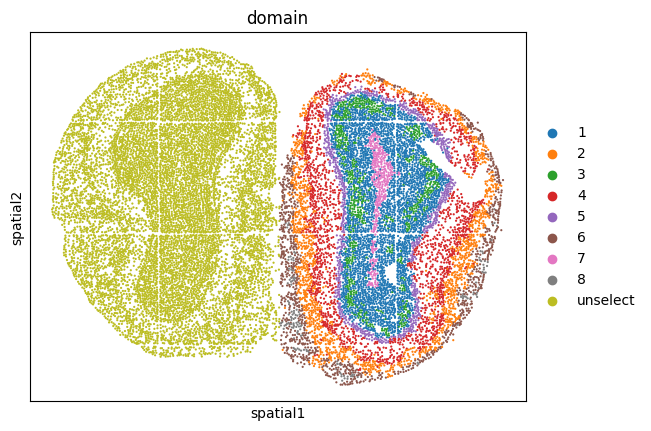

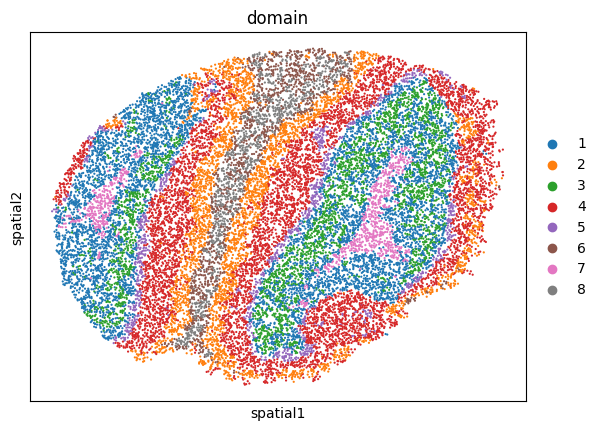

In [7]:
staig.cluster(args.label)
label = staig.adata.obs['domain'].values
labels1 = label[:data1.n_obs]
labels2 = label[data1.n_obs:]


original_data1.obs['domain'] = 'unselect' 

original_data1.obs.loc[data1.obs_names, 'domain'] = labels1

data2.obs['domain'] = 'unselect'
data2.obs.loc[data2.obs_names, 'domain'] = labels2

original_data1.obs['domain'] = original_data1.obs['domain'].astype('category')
data2.obs['domain'] = data2.obs['domain'].astype('category')


sc.pl.embedding(original_data1, basis="spatial", color="domain",size=10,
                    show=True)
sc.pl.embedding(data2, basis="spatial", color="domain",size=10,
                    show=True)

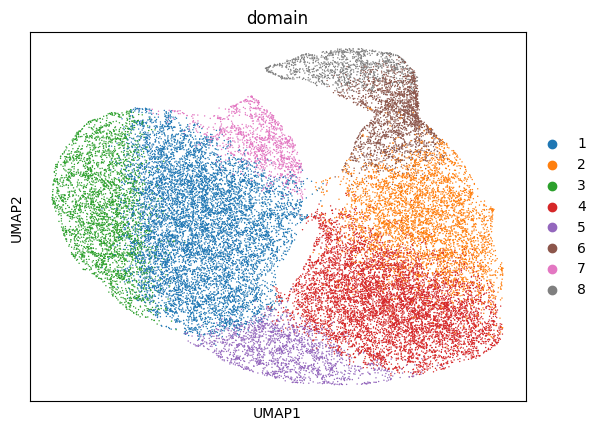

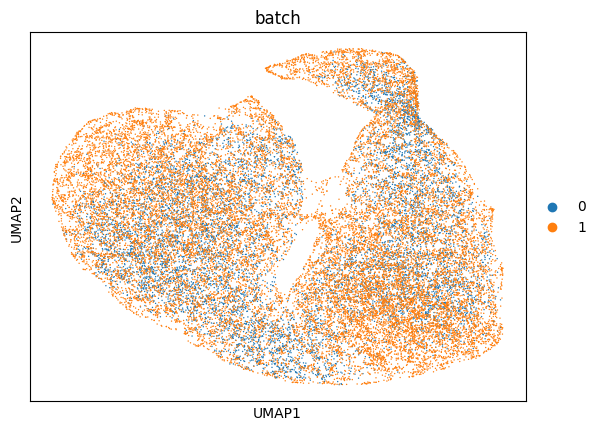

In [9]:
staig.draw_umap()